In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
import pickle, datetime
import Preprocess as pp

import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import  PIL.Image

In [9]:
x_train, y_train, x_test, y_test, N_CATEGORY = pp.load_cat_dog(224, 224, 0.1, 0.1)
# x_train, y_train, x_test, y_test, N_CATEGORY = pp.load_cifar101(227, 227, 0.1, 0.1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, N_CATEGORY)

(2500, 224, 224, 3) (2500,) (2500, 224, 224, 3) (2500,) 2


In [10]:
DROPOUT = 0.5
model_input = Input(shape = (224, 224, 3))

# First convolutional Layer (96x7x7)
z = Conv2D(filters = 96, kernel_size = (7,7), strides = (2,2), activation = "relu")(model_input)
z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = BatchNormalization()(z)

# Second convolutional Layer (256x5x5)
z = Convolution2D(filters = 256, kernel_size = (5,5), 
                  strides = (2,2), activation = "relu")(z)
z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = BatchNormalization()(z)

# Rest 3 convolutional layers
z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 384, kernel_size = (3,3), 
                  strides = (1,1), activation = "relu")(z)

z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 384, kernel_size = (3,3), 
                  strides = (1,1), activation = "relu")(z)

z = ZeroPadding2D(padding = (1,1))(z)
z = Convolution2D(filters = 256, kernel_size = (3,3), 
                  strides = (1,1), activation = "relu")(z)

z = MaxPooling2D(pool_size = (3,3), strides=(2,2))(z)
z = Flatten()(z)

z = Dense(4096, activation="relu")(z)
z = Dropout(DROPOUT)(z)

z = Dense(4096, activation="relu")(z)
z = Dropout(DROPOUT)(z)

final_dim = 1 if N_CATEGORY == 2 else N_CATEGORY
final_act = "sigmoid" if N_CATEGORY == 2 else "softmax"
model_output = Dense(final_dim, activation=final_act)(z)


model = Model(model_input, [model_output])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 96)      14208     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 96)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 54, 54, 96)        384       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 25, 256)       614656    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 12, 256)       1024      
__________

In [ ]:
import time
import pylab as pl
from IPython import display
pl.style.use('ggplot')
%matplotlib inline

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.loss.append(logs['loss'])
        self.val_acc.append(logs['val_acc'])
        self.val_loss.append(logs['val_loss'])
        
        pl.hold(True)
        plt.rcParams["figure.figsize"] = (8,5)
        pl.plot(self.acc, 'r')
        pl.plot(self.loss, 'b')
        pl.plot(self.val_acc, 'g')
        pl.plot(self.val_loss, 'k')
        pl.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

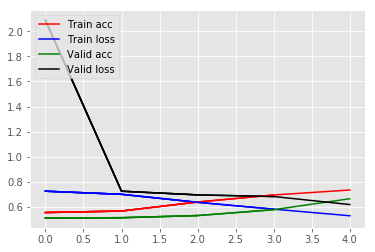

18s - loss: 0.5304 - acc: 0.7356 - val_loss: 0.6197 - val_acc: 0.6660
Epoch 6/100


In [ ]:
WEIGHT_DECAY = 0.0005
MOMENTUM = 0.9
BATCH_SIZE = 128
LEARNING_RATE = 0.01
DROPOUT = 0.5
ALPHA = 1e-4
BETA = 0.75
n = 5
k = 2

loss_metric = "binary_crossentropy" if N_CATEGORY == 2 else "categorical_crossentropy"
model.compile(loss=loss_metric, metrics=["accuracy"], 
              optimizer=optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, decay = WEIGHT_DECAY))

histories = Histories()
res = model.fit(x_train, y_train,
          batch_size = BATCH_SIZE,
          epochs=100, 
          validation_data = (x_test, y_test), verbose=2, callbacks=[histories])